In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline

sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())) + "/..")
if os.getcwd().endswith("Topic2"):
    os.chdir("..")
    print(f"Changed to {os.getcwd()}")

from codebase import load_excel, load_odin_as_ml_dataset, plot_confusion_matrix, make_ml_dataset, run_binary_regression, transport_modes, trip_motives, province_codes

Changed to c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation


In [2]:
# Here just in case
year = 2022
odin_excel_path = os.path.join(os.getcwd(), "data", "OdiN 2019-2023", f"OdiN {year}", f"ODiN{year}_Databestand.csv")
df = load_excel(odin_excel_path)
df = df[df["Verpl"] == 1]

Loaded file from CSV


In [3]:
print(transport_modes)

{1: 'Car - driver', 2: 'Car - passenger', 3: 'Train', 4: 'Bus/tram/metro', 5: 'Bicycle', 6: 'On foot', 7: 'Other'}


In [4]:
print(trip_motives)

{1: 'Work', 2: 'Business', 3: 'Services/personal care', 4: 'Shopping', 5: 'Education', 6: 'Visit/stay overnight', 7: 'Other social/recreational', 8: 'Touring/walking', 9: 'Other motive'}


In [5]:
print(province_codes)

{0: 'No departure point in the Netherlands', 1: 'Groningen', 2: 'Friesland', 3: 'Drenthe', 4: 'Overijssel', 5: 'Flevoland', 6: 'Gelderland', 7: 'Utrecht', 8: 'North Holland', 9: 'South Holland', 10: 'Zeeland', 11: 'North Brabant', 12: 'Limburg', 99: 'Unknown'}


In [6]:
df.columns

Index(['OP', 'OPID', 'Steekproef', 'Mode', 'HHPers', 'HHSam', 'HHPlOP',
       'HHLft1', 'HHLft2', 'HHLft3',
       ...
       'RReisduur', 'RReisduurBL', 'RVertStat', 'RAankStat', 'RTSamen',
       'RCorrSnelh', 'RVliegVer', 'FactorH', 'FactorP', 'FactorV'],
      dtype='object', length=247)

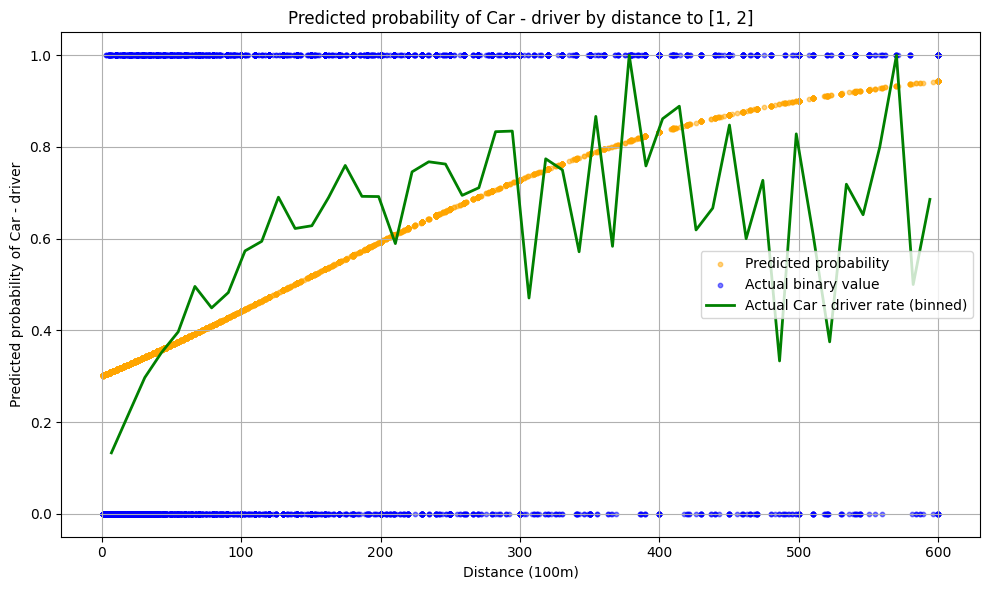

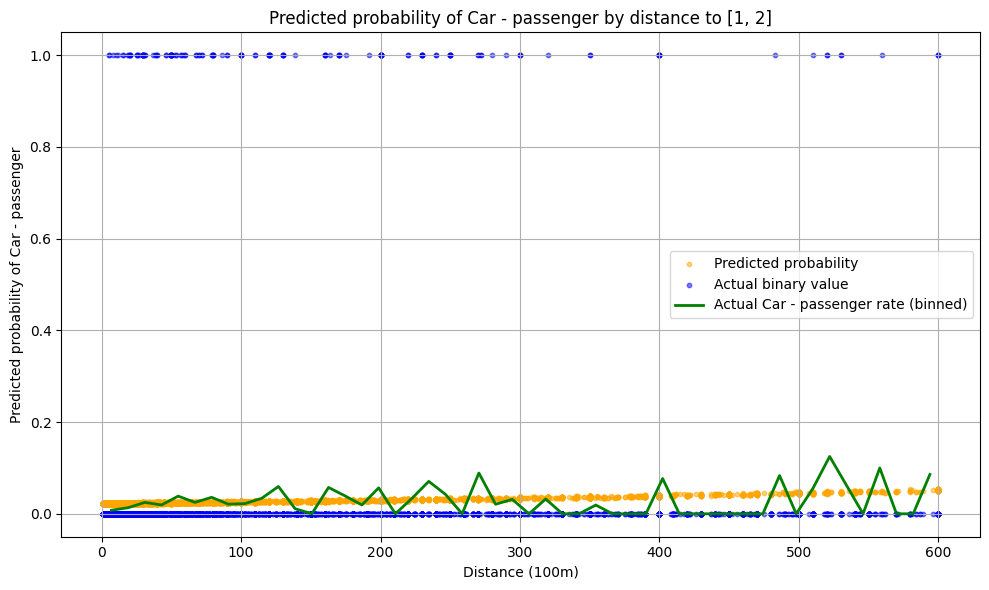

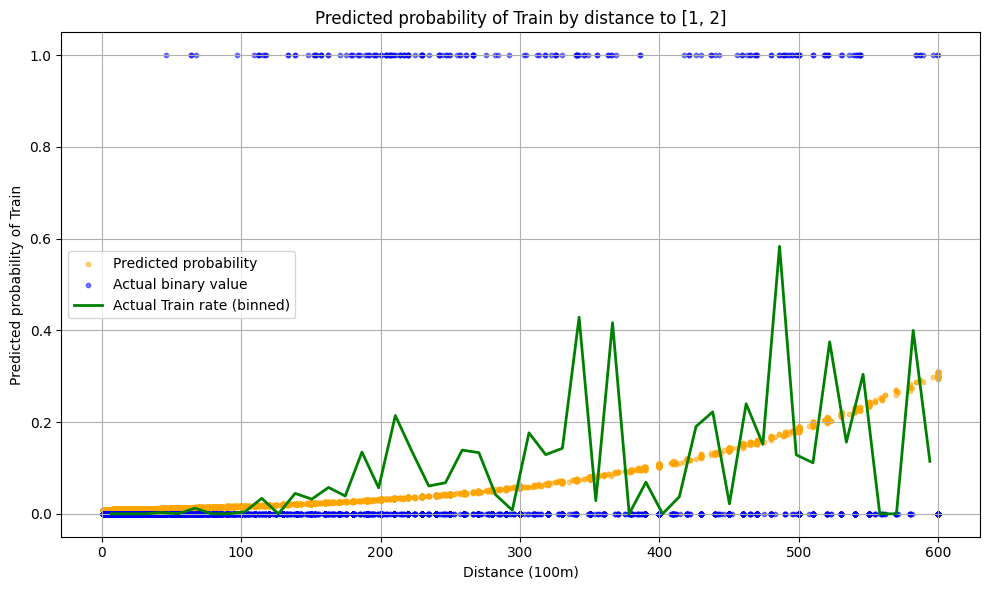

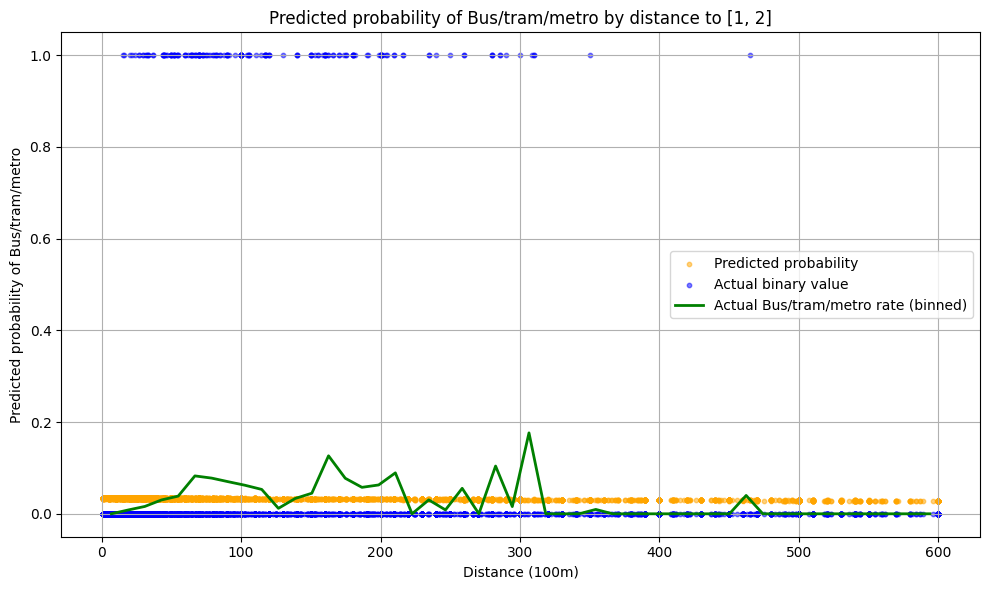

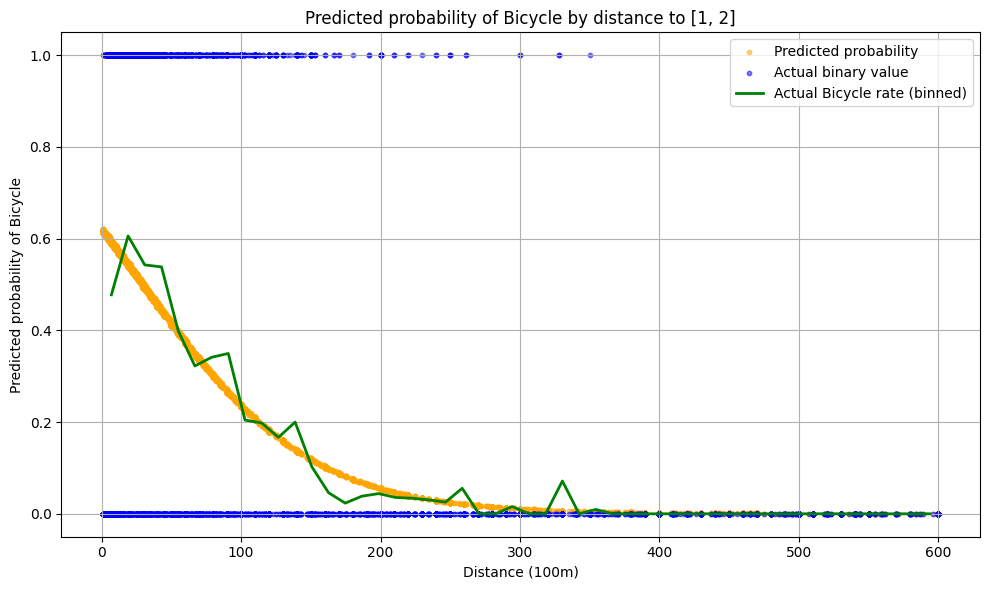

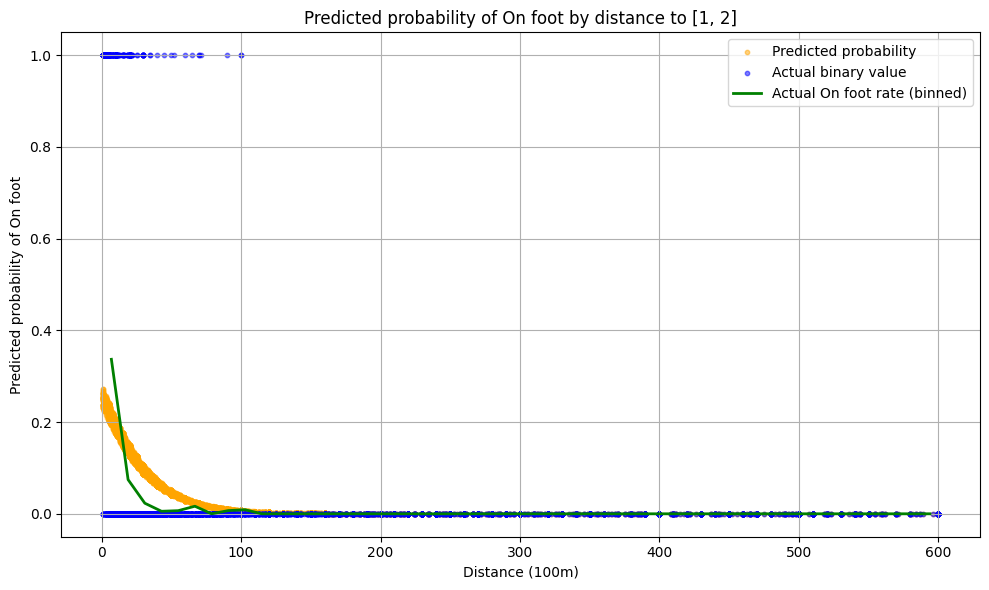

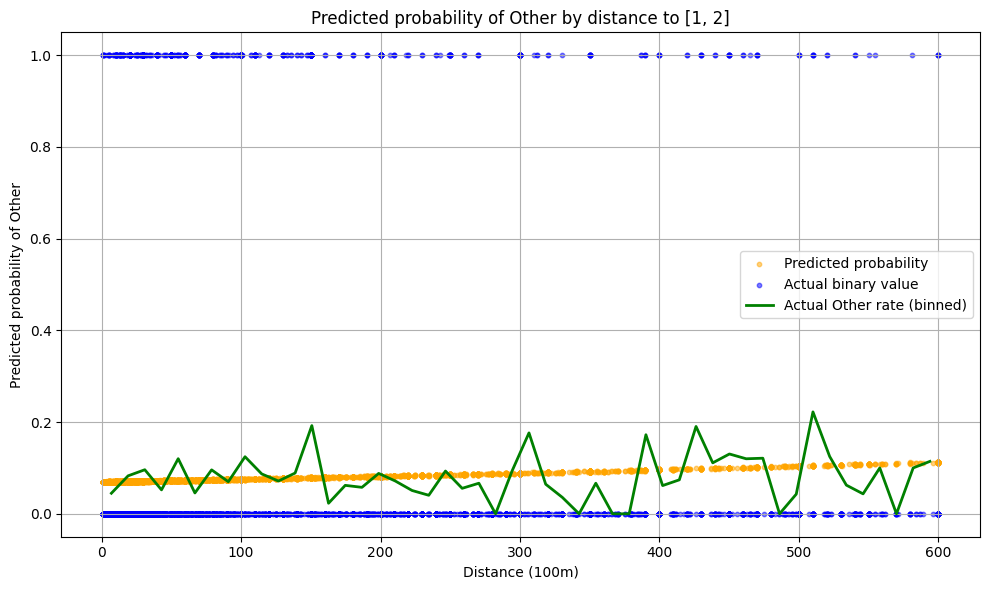

In [7]:
max_dist=600 # max distance in 100s of meters
motives=[1, 2] 

for transport_mode in transport_modes.keys():
    run_binary_regression(
        df,
        test_size=0.2,
        transport_mode=transport_mode,
        motives=motives,
        max_dist=max_dist,
        savename=f"graphics/classification_results/binary_regression/{motives}/{transport_modes[transport_mode].replace(r'/', ' or ')}_{max_dist}",
    )

Now a classifier that classifies what mode of transport was used

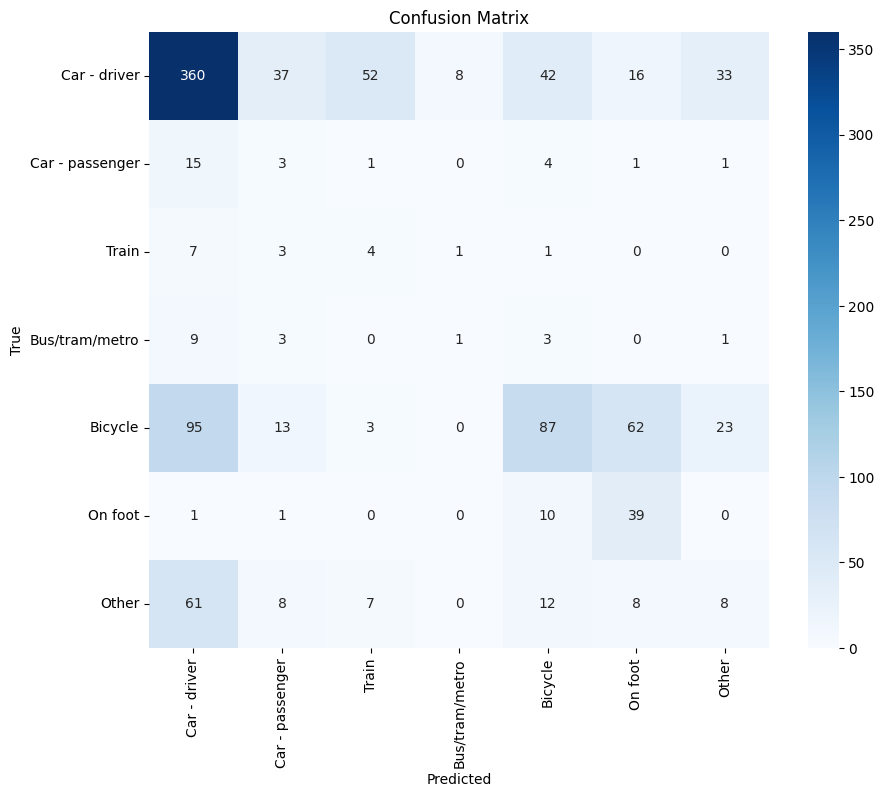

                 precision    recall  f1-score   support

   Car - driver       0.66      0.66      0.66       548
Car - passenger       0.04      0.12      0.06        25
          Train       0.06      0.25      0.10        16
 Bus/tram/metro       0.10      0.06      0.07        17
        Bicycle       0.55      0.31      0.39       283
        On foot       0.31      0.76      0.44        51
          Other       0.12      0.08      0.09       104

       accuracy                           0.48      1044
      macro avg       0.26      0.32      0.26      1044
   weighted avg       0.52      0.48      0.49      1044



(Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(class_weight='balanced', max_depth=10,
                                         n_jobs=-1, random_state=42))]),
 (                OPID   AfstV  VertPC_4254.0  VertPC_4255.0  VertPC_4261.0  \
  24      300001981980   540.0          False          False          False   
  40      300003981980   350.0          False          False          False   
  41      300003981980   350.0          False          False          False   
  137     300007789880  1190.0          False          False          False   
  226     300012981980    30.0          False          False          False   
  ...              ...     ...            ...            ...            ...   
  199847  309993879880    50.0          False          False          False   
  199848  309993879880    80.0          False          False          False   
  199849  309993882980    25.0          F

In [8]:
from codebase import run_multiclass_classification, distance_col, origin_col, province_codes, level_mapping_suffix

motives=[1, 2]
origins=[11, 12]
location_level=2
categorical_features=[origin_col]
numerical_features=[distance_col]

run_multiclass_classification(
    df,
    test_size=0.2,
    destinations=None,
    origins=origins,
    location_level=location_level,
    categorical_features=categorical_features,
    numerical_features=numerical_features,
    motives=motives,
    plot=True,
    savename=f"graphics/classification_results/multiclass/{level_mapping_suffix[location_level]}/{origins}/{motives}/{categorical_features + numerical_features}",
)